# Baseline Model

In [1]:
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline




In [2]:
# Load data
X_train = joblib.load("Data/Xtrain2.pkl")
Y_train = np.load('Data/Ytrain2.npy')

print(X_train.shape)
print(Y_train.shape)

(444, 3)
(14,)


In [3]:
# FILTERING OPTIONS - MODIFY THESE TO REMOVE EXERCISES OR PATIENTS

# Option 1: Remove specific exercises
# exercises_to_remove = ['E1', 'E2']  # Remove exercises E1 and E2
exercises_to_remove = []  # Keep all exercises

# Option 2: Remove specific patients
# patients_to_remove = [1, 5, 10]  # Remove patients 1, 5, and 10
patients_to_remove = []  # Keep all patients

In [4]:
# Apply filters if specified
if exercises_to_remove:
    original_count = len(X_train)
    X_train = X_train[~X_train['Exercise_Id'].isin(exercises_to_remove)]
    print(f"Removed exercises {exercises_to_remove}. Sequences: {original_count} -> {len(X_train)}")

if patients_to_remove:
    original_count = len(X_train)
    X_train = X_train[~X_train['Patient_Id'].isin(patients_to_remove)]
    print(f"Removed patients {patients_to_remove}. Sequences: {original_count} -> {len(X_train)}")

# Get patient IDs from the filtered data
patient_ids = np.sort(X_train['Patient_Id'].unique())
print(f"Patient IDs in filtered data: {patient_ids}")

Patient IDs in filtered data: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [5]:
# Create patient-to-label mapping from the original Y_train
# We need to filter Y_train to only include patients that remain after filtering
all_patient_to_label = dict(zip(range(1, 15), Y_train))  # Original mapping for patients 1-14
patient_to_label = {pid: all_patient_to_label[pid] for pid in patient_ids}
Y_train_filtered = np.array([patient_to_label[pid] for pid in patient_ids])

print(f"Filtered data: {X_train.shape[0]} sequences, {len(patient_ids)} patients")
print(f"Class distribution: {np.sum(Y_train_filtered==0)} left vs {np.sum(Y_train_filtered==1)} right impaired")

Filtered data: 444 sequences, 14 patients
Class distribution: 9 left vs 5 right impaired


In [ ]:
# Load feature importance data
feature_importance_df = pd.read_csv('Data/feature_importance_v1_baseline.csv')
print(f"Loaded feature importance data: {len(feature_importance_df)} rows")

# Create feature name to index mapping
keypoint_names = [
    'nose', 'left_eye_inner', 'left_eye', 'left_eye_outer', 'right_eye_inner', 'right_eye', 'right_eye_outer',
    'left_ear', 'right_ear', 'mouth_left', 'mouth_right', 'left_shoulder', 'right_shoulder',
    'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky',
    'left_index', 'right_index', 'left_thumb', 'right_thumb', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle', 'left_heel', 'right_heel',
    'left_foot_index', 'right_foot_index'
]

feature_to_index = {}
for i, name in enumerate(keypoint_names):
    feature_to_index[f'{name}_mean_x'] = (i, 'mean_x')
    feature_to_index[f'{name}_mean_y'] = (i, 'mean_y')
    feature_to_index[f'{name}_var_x'] = (i, 'var_x')
    feature_to_index[f'{name}_var_y'] = (i, 'var_y')

Loaded feature importance data: 685 rows


In [7]:
# Function to create feature mask for top N features per exercise
def create_top_n_mask(n_features_per_exercise):
    mask_dict = {}
    
    for exercise in ['E1', 'E2', 'E3', 'E4', 'E5']:
        # Get top N features for this exercise
        top_features = feature_importance_df[
            feature_importance_df['exercise'] == exercise
        ].nlargest(n_features_per_exercise, 'importance')
        
        mask_dict[exercise] = {}
        
        for _, row in top_features.iterrows():
            feature_name = row['feature']
            if feature_name in feature_to_index:
                kp_idx, component = feature_to_index[feature_name]
                if kp_idx not in mask_dict[exercise]:
                    mask_dict[exercise][kp_idx] = []
                if component not in mask_dict[exercise][kp_idx]:
                    mask_dict[exercise][kp_idx].append(component)
    
    return mask_dict

In [8]:
# Feature extraction function with dynamic top-N masking
def extract_features_with_top_n_masking(df, top_n_mask):
    features_list = []
    
    for idx, row in df.iterrows():
        skeleton_seq = row['Skeleton_Sequence']
        exercise_id = row['Exercise_Id']
        
        # Get feature mask configuration for this exercise
        feature_mask_config = top_n_mask.get(exercise_id, {})
        
        # Ensure skeleton_seq is 3D: (seq_length, 33, 2)
        if skeleton_seq.ndim == 2 and skeleton_seq.shape[1] == 66:
            skeleton_seq = skeleton_seq.reshape(skeleton_seq.shape[0], 33, 2)
        
        # Calculate means and variances for all keypoints first
        flattened = skeleton_seq.reshape(len(skeleton_seq), -1)  # (seq_length, 66)
        all_means = np.mean(flattened, axis=0)  # 66 features
        all_variances = np.var(flattened, axis=0)  # 66 features
        
        # Apply granular masking - only keep specified features
        final_means = np.zeros(66)
        final_variances = np.zeros(66)
        
        # For each keypoint in the mask configuration, keep specified components
        for kp_idx, components_to_keep in feature_mask_config.items():
            # Each keypoint has 2 positions in the mean/variance arrays
            mean_x_idx = kp_idx * 2
            mean_y_idx = kp_idx * 2 + 1
            var_x_idx = kp_idx * 2
            var_y_idx = kp_idx * 2 + 1
            
            if 'mean_x' in components_to_keep:
                final_means[mean_x_idx] = all_means[mean_x_idx]
            if 'mean_y' in components_to_keep:
                final_means[mean_y_idx] = all_means[mean_y_idx]
            if 'var_x' in components_to_keep:
                final_variances[var_x_idx] = all_variances[var_x_idx]
            if 'var_y' in components_to_keep:
                final_variances[var_y_idx] = all_variances[var_y_idx]
        
        features_list.append(np.concatenate([final_means, final_variances]))
    
    return np.array(features_list)

In [9]:
# Test different numbers of top features
#n_features_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # Initial
n_features_list = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]  # Specific
n_splits = 364  

results = {
    'n_features': [],
    'majority_accuracies': [],
    'probability_accuracies': [],
}

In [10]:
for n_features in tqdm(n_features_list, desc="Testing feature counts"):
    # Create mask for current number of features
    top_n_mask = create_top_n_mask(n_features)
    
    # Extract features with current mask
    X_all_features = extract_features_with_top_n_masking(X_train, top_n_mask)
    
    # Prepare one-hot encoder for exercises
    exercise_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    exercise_encoded = exercise_encoder.fit_transform(X_train[['Exercise_Id']])
    
    # Combine features with exercise encoding
    X_combined = np.concatenate([X_all_features, exercise_encoded], axis=1)
    
    # Create sequence-level labels
    y_sequences = X_train['Patient_Id'].map(patient_to_label).values
    
    # Store patient ID for each sequence
    sequence_patient_ids = X_train['Patient_Id'].values
    
    majority_accuracies = []
    probability_accuracies = []
    
    for split in range(n_splits):
        # Random stratified split: 2 left + 1 right patients for test
        rng = np.random.RandomState(42 + split)
        
        left_patients = patient_ids[Y_train_filtered == 0]
        right_patients = patient_ids[Y_train_filtered == 1]
        
        test_left = rng.choice(left_patients, size=2, replace=False)
        test_right = rng.choice(right_patients, size=1, replace=False)
        test_patients = np.concatenate([test_left, test_right])
        train_patients = np.setdiff1d(patient_ids, test_patients)
        
        # Create masks for sequences
        train_mask = np.isin(sequence_patient_ids, train_patients)
        test_mask = np.isin(sequence_patient_ids, test_patients)
        
        # Split the precomputed features
        X_train_split = X_combined[train_mask]
        X_test_split = X_combined[test_mask]
        y_train_split = y_sequences[train_mask]
        test_patient_ids_split = sequence_patient_ids[test_mask]
        
        # Train SVM
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42))
        ])
        
        model.fit(X_train_split, y_train_split)
        
        # Get predictions and probabilities
        test_sequence_preds = model.predict(X_test_split)
        test_sequence_probs = model.predict_proba(X_test_split)
        
        # METHOD 1: Majority Voting
        patient_predictions = {}
        for i, patient_id in enumerate(test_patient_ids_split):
            if patient_id not in patient_predictions:
                patient_predictions[patient_id] = []
            patient_predictions[patient_id].append(test_sequence_preds[i])
        
        majority_preds = []
        true_labels = []
        for patient_id in test_patients:
            votes = patient_predictions[patient_id]
            pred_label = np.argmax(np.bincount(votes))
            majority_preds.append(pred_label)
            true_labels.append(patient_to_label[patient_id])
        
        majority_acc = balanced_accuracy_score(true_labels, majority_preds)
        majority_accuracies.append(majority_acc)
        
        # METHOD 2: Probability Averaging
        patient_probs = {}
        for i, patient_id in enumerate(test_patient_ids_split):
            if patient_id not in patient_probs:
                patient_probs[patient_id] = []
            patient_probs[patient_id].append(test_sequence_probs[i])
        
        probability_preds = []
        for patient_id in test_patients:
            avg_probs = np.mean(patient_probs[patient_id], axis=0)
            pred_label = np.argmax(avg_probs)
            probability_preds.append(pred_label)
        
        probability_acc = balanced_accuracy_score(true_labels, probability_preds)
        probability_accuracies.append(probability_acc)
    
    # Store results
    # Store the actual
    results['n_features'].append(n_features)
    results['majority_accuracies'].append(majority_accuracies)
    results['probability_accuracies'].append(probability_accuracies)
    

Testing feature counts:   0%|          | 0/11 [00:00<?, ?it/s]

Testing feature counts: 100%|██████████| 11/11 [01:55<00:00, 10.52s/it]


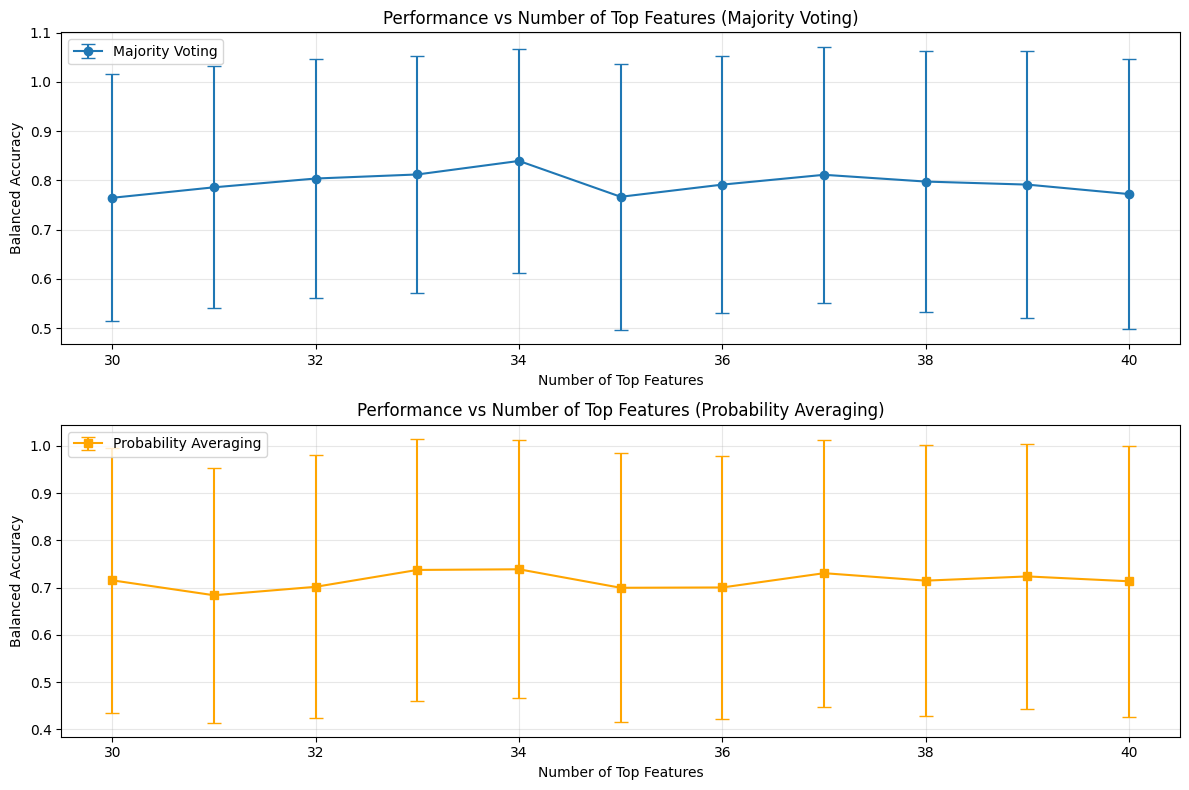

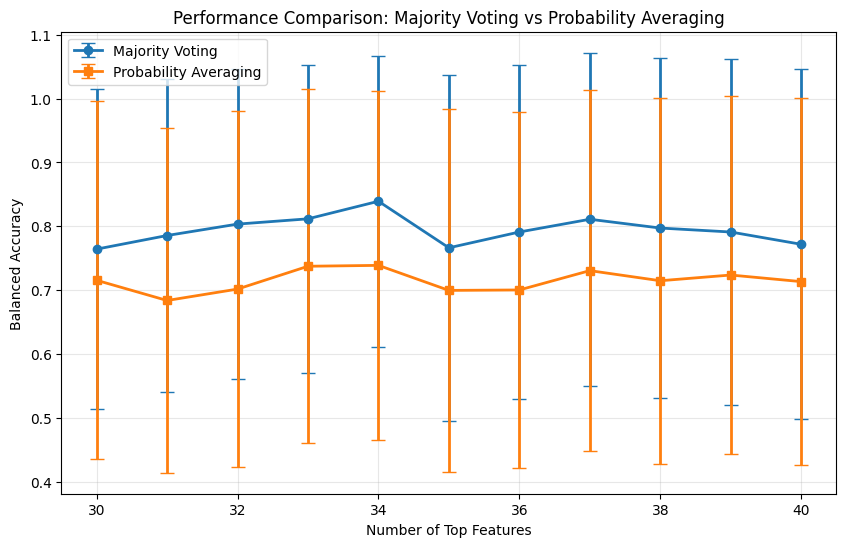

In [11]:
# Convert results to DataFrame using the stored accuracy lists
results_df = pd.DataFrame({
    'n_features': results['n_features'],
    'majority_mean': [np.mean(acc) for acc in results['majority_accuracies']],
    'majority_std': [np.std(acc) for acc in results['majority_accuracies']],
    'probability_mean': [np.mean(acc) for acc in results['probability_accuracies']],
    'probability_std': [np.std(acc) for acc in results['probability_accuracies']]
})

# Plot results
plt.figure(figsize=(12, 8))

# Majority voting plot
plt.subplot(2, 1, 1)
plt.errorbar(results_df['n_features'], results_df['majority_mean'], 
             yerr=results_df['majority_std'], marker='o', capsize=5, label='Majority Voting')
plt.xlabel('Number of Top Features')
plt.ylabel('Balanced Accuracy')
plt.title('Performance vs Number of Top Features (Majority Voting)')
plt.grid(True, alpha=0.3)
plt.legend()

# Probability averaging plot
plt.subplot(2, 1, 2)
plt.errorbar(results_df['n_features'], results_df['probability_mean'], 
             yerr=results_df['probability_std'], marker='s', capsize=5, 
             color='orange', label='Probability Averaging')
plt.xlabel('Number of Top Features')
plt.ylabel('Balanced Accuracy')
plt.title('Performance vs Number of Top Features (Probability Averaging)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(10, 6))
plt.errorbar(results_df['n_features'], results_df['majority_mean'], 
             yerr=results_df['majority_std'], marker='o', capsize=5, 
             label='Majority Voting', linewidth=2)
plt.errorbar(results_df['n_features'], results_df['probability_mean'], 
             yerr=results_df['probability_std'], marker='s', capsize=5, 
             label='Probability Averaging', linewidth=2)
plt.xlabel('Number of Top Features')
plt.ylabel('Balanced Accuracy')
plt.title('Performance Comparison: Majority Voting vs Probability Averaging')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [12]:
# Then for the final results:
optimal_majority_idx = np.argmax([np.mean(acc) for acc in results['majority_accuracies']])
optimal_probability_idx = np.argmax([np.mean(acc) for acc in results['probability_accuracies']])

optimal_majority_features = results['n_features'][optimal_majority_idx]
optimal_probability_features = results['n_features'][optimal_probability_idx]

optimal_majority_accuracies = results['majority_accuracies'][optimal_majority_idx]
optimal_probability_accuracies = results['probability_accuracies'][optimal_probability_idx]

print("\n=== OPTIMAL RESULTS ===\n")
print(f"MAJORITY VOTING (Best: {optimal_majority_features} features):")
print(f"  Mean Balanced Accuracy: {np.mean(optimal_majority_accuracies):.4f} (±{np.std(optimal_majority_accuracies):.4f})")
print(f"  Min: {np.min(optimal_majority_accuracies):.4f}, Max: {np.max(optimal_majority_accuracies):.4f}")

print(f"\nPROBABILITY AVERAGING (Best: {optimal_probability_features} features):")
print(f"  Mean Balanced Accuracy: {np.mean(optimal_probability_accuracies):.4f} (±{np.std(optimal_probability_accuracies):.4f})")
print(f"  Min: {np.min(optimal_probability_accuracies):.4f}, Max: {np.max(optimal_probability_accuracies):.4f}")


=== OPTIMAL RESULTS ===

MAJORITY VOTING (Best: 34 features):
  Mean Balanced Accuracy: 0.8393 (±0.2276)
  Min: 0.0000, Max: 1.0000

PROBABILITY AVERAGING (Best: 34 features):
  Mean Balanced Accuracy: 0.7390 (±0.2734)
  Min: 0.2500, Max: 1.0000
